#### Understanding metrics for classification models
Since accuracy is not always an informative metric I'll dive more deeply into evaluating the performance of binary classifiers by computing a confusion matrix and generating a classification report. In so doing, I'll use the [diabetes](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetesl) dataset to predict whether or not a given female patient will contract diabetes based on features such as BMI, age, and number of pregnancies. Additionally, we'll measure the efficacy of two estimators to get a sense for which one makes the best prediction tool in this scenario. Instantiate, fit, and predict should become like second nature for any estimator.

In [28]:
# Import necessary modules to get started
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [29]:
#import the data of interest
df = pd.read_csv('datasets/diabetes.csv')

# Create arrays for features and the target variable
y = df['diabetes'].values
X = df.drop('diabetes', axis=1).values

# Create training and test set that I can use in both estimators
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

df.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [30]:
# Import the first estimator, k-NN
from sklearn.neighbors import KNeighborsClassifier

# Instantiate a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = knn.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[176  30]
 [ 56  46]]
             precision    recall  f1-score   support

          0       0.76      0.85      0.80       206
          1       0.61      0.45      0.52       102

avg / total       0.71      0.72      0.71       308



The values in the confusion matrix ```[[176  30][ 56  46]]``` correspond as follows: 

<img src="assets/confusion_matrix.png" align="left">

In [31]:
# Now I'll give Logistic Regression a chance to shine.
from sklearn.linear_model import LogisticRegression

# Create the classifier
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[174  32]
 [ 36  66]]
             precision    recall  f1-score   support

          0       0.83      0.84      0.84       206
          1       0.67      0.65      0.66       102

avg / total       0.78      0.78      0.78       308



##### Plotting an ROC curve
Classification reports and confusion matrices are great methods to quantitatively evaluate model performance, while ROC curves provide a way to visually evaluate models. I'll now evaluate its performance by plotting an ROC curve. In doing so, I'll make use of the `.predict_proba()` method and become familiar with its functionality.

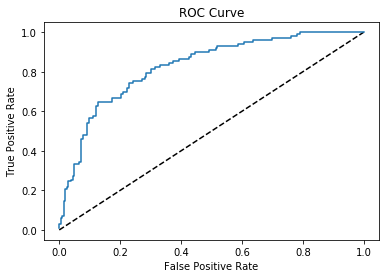

In [32]:
# Import the necessary module to plot LogReg's ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

# Compute predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values (false positive rate, true positive rate, thresholds)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Area under the curve (AUC)
When looking at the ROC curve above, note that the y-axis (True positive rate) is also known as recall.

Say you have a binary classifier that in fact is just randomly making guesses. It would be correct approximately 50% of the time, and the resulting ROC curve would be a diagonal line in which the True Positive Rate and False Positive Rate are always equal. The area under this ROC curve would be 0.5. This is one way in which the AUC is an informative metric to evaluate a model. If the AUC is greater than 0.5, the model is better than random guessing. I'll try that now.

In [33]:
# Import necessary modules to compute ROC area under the curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores
cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.826860841424
AUC scores computed using 5-fold cross-validation: [0.7987037  0.80777778 0.81944444 0.86622642 0.85037736]


#### Hyperparameter tuning with GridSearchCV and RandomSearchCV
GridSearchCV can be computationally expensive, especially if searching over a large hyperparameter space and dealing with multiple hyperparameters. Because of this I'll demostrate the use of both GridSearchCV and RandomSearchCV over a decision tree estimator. In both examples I won't use the holdout data, but rather I'll save that for the final two bits and bobs of this analysis.

In [24]:
# Import the necessary GridSearchCV module 
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 268.2695795279727}
Best score is 0.770833333333


In [25]:
# Import the necessary modules
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_features': 5, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8}
Best score is 0.75390625


##### Holdout data
Now I'll bring in the hold out data from previous analysis above in order to practice evaluating a model with tuned hyperparameters. First I'll try GridSearchCV `logreg`, which in addition to `C` has a 'penalty' hyperparameter which specifies whether to use `l1` or `l2` regularization. Finally I'll give use an `ElasticNet` model where the penalty term is a linear combination of the `l1` and `l2` penalties

In [26]:
# Create the hyperparameter grid and make use of LogReg's 'Penalty' Hyperparameter
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'penalty': 'l2', 'C': 31.622776601683793}
Tuned Logistic Regression Accuracy: 0.767391304348


In [27]:
# Import the neccessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate an ElasticNet regressor
elastic_net = ElasticNet()

# Setup the GridSearchCV object
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.247653375107
Tuned ElasticNet MSE: 0.166641795436
